# 2. Data Preprocessing (California Housing)

This notebook follows the class notes on data preprocessing and applies them to the **California Housing** dataset. We will:
- Inspect data format
- Identify and correct erroneous values
- Detect and treat outliers
- Normalize numerical attributes
- Disaggregate categorical variables (after creating a categorical feature)
- Categorize numerical variables

All preprocessing steps are explicit, justified, and documented.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

In [2]:
# Load California housing dataset
cal = fetch_california_housing(as_frame=True)
cal_data = cal.frame.copy()
cal_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Create a Dirty Version of the Dataset

To practice preprocessing, we will intentionally introduce **erroneous values** (e.g., "NA") and **outliers** into a copy of the dataset. We keep the original data intact.

In [3]:
# Make a dirty copy (deterministic for reproducibility)
cal_dirty = cal_data.copy()

rng = np.random.default_rng(42)

# Identify candidate columns
num_cols = cal_dirty.select_dtypes(include='number').columns.tolist()

# Erroneous value tokens (common in real datasets)
err_tokens = ["NA", "N/A", "?", "", " ", "nan", "NaN", "None", "null", "NULL", "-"]

# 1) Introduce erroneous values across multiple numeric columns
if num_cols:
    n_err = max(1, int(0.02 * len(cal_dirty)))  # 2% of rows
    for col in num_cols[:3]:  # affect first 3 numeric columns
        rows = rng.choice(cal_dirty.index, size=n_err, replace=False)
        cal_dirty.loc[rows, col] = rng.choice(err_tokens, size=n_err)

# 2) Introduce missing values (np.nan) in more numeric columns
if num_cols:
    n_miss = max(1, int(0.015 * len(cal_dirty)))  # 1.5% of rows
    for col in num_cols[3:6]:  # next 3 numeric columns (if any)
        rows = rng.choice(cal_dirty.index, size=n_miss, replace=False)
        cal_dirty.loc[rows, col] = np.nan

# 3) Introduce outliers in multiple numeric columns
if num_cols:
    n_out = max(1, int(0.005 * len(cal_dirty)))  # 0.5% of rows
    for col in num_cols[:4]:  # outliers in first 4 numeric columns
        rows = rng.choice(cal_dirty.index, size=n_out, replace=False)
        numeric_series = pd.to_numeric(cal_dirty[col], errors='coerce')
        max_val = numeric_series.max()
        cal_dirty.loc[rows, col] = max_val * rng.integers(20, 60, size=n_out)

# Quick check
print("Original missing values:")
print(cal_data.isna().sum().head())
print("Dirty missing values (after injection):")
print(cal_dirty.isna().sum().head())

cal_dirty.head()

Original missing values:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
dtype: int64
Dirty missing values (after injection):
MedInc          0
HouseAge        0
AveRooms        0
AveBedrms     309
Population    309
dtype: int64


/var/folders/b0/dnzc9blx30bfgp8x152ckgg00000gn/T/ipykernel_47579/2830419433.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['None' 'NaN' 'NA' 'None' 'NULL' 'NULL' 'NA' '?' '?' ' ' 'N/A' 'NULL'
 'null' 'null' '?' 'NA' '-' '' 'None' '-' 'NA' 'NA' 'NA' 'N/A' 'NA' 'NULL'
 'NaN' '-' 'null' '-' '?' '' 'NULL' '?' 'NA' 'None' 'null' '-' '-' 'N/A'
 'null' 'NULL' 'None' 'NULL' 'NULL' ' ' 'NA' 'nan' '?' 'N/A' 'N/A' 'None'
 'nan' 'nan' 'null' 'NaN' 'NaN' 'NA' 'NULL' ' ' 'N/A' 'null' 'null' 'NA'
 '?' 'NA' '?' 'N/A' 'None' 'nan' '-' 'null' 'NaN' 'nan' 'NA' 'NA' 'NaN'
 'NA' 'NA' '?' 'NULL' 'nan' 'None' ' ' 'N/A' ' ' 'N/A' 'null' '?' ' ' '-'
 'NaN' 'nan' 'nan' 'null' '?' 'None' 'NULL' 'NaN' ' ' 'N/A' '?' '-' 'nan'
 '' ' ' 'NaN' 'nan' 'None' '?' 'None' ' ' '-' 'N/A' 'N/A' 'nan' 'nan'
 'None' ' ' '-' 'nan' 'N/A' 'N/A' '-' 'N/A' '-' '' 'N/A' '' 'NaN' ' '
 'null' 'NaN' ' ' 'NaN' '-' ' ' 'N/A' ' ' 'NULL' '?' '-' 'NaN' 

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,NaN,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## 1. Data Preprocessing

Data preprocessing is the set of transformations required to make data suitable for machine learning. It is necessary but must be done carefully to avoid introducing bias or errors.

Key principle: **all transformations must be explicit, justified, and documented**.

## 2. Format

A dataset is a collection of data points (rows) described by attributes (columns). Attributes may be:
- Categorical (finite set of values)
- Numerical (continuous values)
- Text (strings)
- Other (images, sounds, dates, etc.)

We first inspect the dataset format and types.

In [4]:
# Basic inspection
print(cal_data.shape)
display(cal_data.head())

# Data types and missing values overview
cal_data.info()

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
# Separate columns by type
num_cols = cal_data.select_dtypes(include='number').columns.tolist()
cat_cols = cal_data.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numerical columns:", num_cols)
print("Categorical/Text columns:", cat_cols)

Numerical columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']
Categorical/Text columns: []


### 2.2 Data Format considerations

We need to consider:
- Character encoding (e.g., special characters like ñ)
- Numbers (decimal/thousand separators, units)
- Categorical values (consistent spelling/casing)
- Erroneous values (tokens that represent missing values)

## 3. Erroneous Values

Erroneous values are invalid for an attribute (not outliers). Typical causes:
- Missing values
- Incorrect format (e.g., "30,0" instead of "30.0")
- Measurement errors
- Encoding errors
- Nonexistent categories

We first detect common missing-value tokens and format issues.

In [6]:
# Common missing-value tokens observed in real datasets
missing_tokens = ["NA", "N/A", "?", "", " ", "nan", "NaN", "None", "null", "NULL", "-"]

# Replace tokens with NaN for consistent handling
clean = cal_dirty.replace(missing_tokens, np.nan)

# Coerce numeric columns to numeric (invalid strings become NaN)
for col in num_cols:
    clean[col] = pd.to_numeric(clean[col], errors='coerce')

missing_counts = clean.isna().sum().sort_values(ascending=False)
missing_counts[missing_counts > 0].head(15)

/var/folders/b0/dnzc9blx30bfgp8x152ckgg00000gn/T/ipykernel_47579/1936359525.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean = cal_dirty.replace(missing_tokens, np.nan)


MedInc        412
HouseAge      412
AveRooms      412
AveBedrms     309
Population    309
AveOccup      309
dtype: int64

### 3.5 Correction strategies

Typical strategies:
- Remove rows or columns with erroneous values
- Correct values when the fix is unambiguous
- Impute missing values (mean, median, mode, fixed value, or a model)

Below we show a simple imputation strategy.

In [7]:
# Simple imputation example
imputed = clean.copy()

# Numerical: median (robust to outliers)
for col in num_cols:
    if imputed[col].isna().any():
        imputed[col] = imputed[col].fillna(imputed[col].median())

imputed.isna().sum().sort_values(ascending=False).head(10)

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

## 4. Outliers

Outliers are values that deviate significantly from the distribution. They can strongly affect models.

Detection is subjective and context-dependent. Common rules:
- More than N standard deviations from the mean (e.g., N=3)
- Above or below percentile P (e.g., P=95)
- Low probability under the distribution (e.g., p < 0.01)

In [8]:
# Choose a numerical column to illustrate outlier detection
num_col = num_cols[0]

# Z-score and IQR detection for the chosen column
x = imputed[num_col]

# Z-score method
z = (x - x.mean()) / x.std()
outliers_z = imputed[np.abs(z) > 3]

# IQR method
q1, q3 = x.quantile(0.25), x.quantile(0.75)
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
outliers_iqr = imputed[(x < lower) | (x > upper)]

print(f"Column: {num_col}")
print("Outliers (Z-score > 3):", len(outliers_z))
print("Outliers (IQR rule):", len(outliers_iqr))

outliers_iqr[[num_col]].head()

Column: MedInc
Outliers (Z-score > 3): 103
Outliers (IQR rule): 779


,MedInc
0,8.3252
1,8.3014
131,11.6017
134,8.2049
135,8.4010


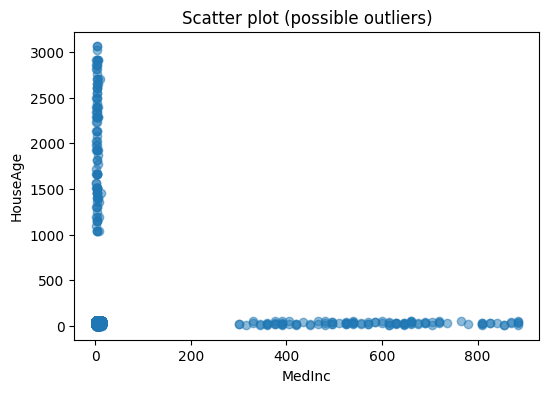

In [9]:
# Optional visualization with two numerical features
plt.figure(figsize=(6,4))
plt.scatter(imputed[num_cols[0]], imputed[num_cols[1]], alpha=0.5)
plt.xlabel(num_cols[0])
plt.ylabel(num_cols[1])
plt.title("Scatter plot (possible outliers)")
plt.show()

### 4.3 Treatment

Outlier treatment is often similar to erroneous values:
- Remove
- Correct (if clearly wrong)
- Impute or cap (winsorization)

## 5. Normalization

Normalization transforms numerical data to satisfy specific properties:
- Range (e.g., [0, 1])
- Unit (consistent measurement units)
- Scale (attributes comparable for distance-based models)

We use two common techniques: **standardization** and **scaling**.

In [10]:
# Standardization (mean 0, std 1) and Min-Max scaling [0,1]
normalized = imputed.copy()

# Standardization
normalized[num_cols] = (normalized[num_cols] - normalized[num_cols].mean()) / normalized[num_cols].std()

# Scaling
scaled = imputed.copy()
scaled[num_cols] = (scaled[num_cols] - scaled[num_cols].min()) / (scaled[num_cols].max() - scaled[num_cols].min())

normalized[num_cols].head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0.038217,0.016889,-0.063817,-0.068764,-0.978252,-0.024116,1.052523,-1.327803,2.129580
1,0.037650,-0.119633,-0.065710,-0.069299,0.872307,-0.092285,1.043159,-1.322812,1.314124
2,0.012808,0.091976,-0.060507,-0.068253,-0.823371,-0.025614,1.038478,-1.332794,1.258663
3,-0.025604,0.091976,-0.066778,-0.068257,-0.768184,-0.050102,1.038478,-1.337785,1.165072
4,-0.068362,0.091976,-0.065599,-0.068175,-0.761953,-0.085389,1.038478,-1.337785,1.172871


## 6. Disaggregation

Disaggregation converts categorical attributes into numerical features so they can be used by ML algorithms.

The California Housing dataset is fully numeric, so we will create a categorical feature for demonstration (e.g., binning `MedInc`).

In [11]:
# Create a categorical feature from a numeric one
cal_cat = imputed.copy()
cal_cat["MedInc_bin"] = pd.qcut(cal_cat["MedInc"], q=4, labels=["low", "mid", "high", "very_high"])

# Label encoding
cal_cat["MedInc_label"] = cal_cat["MedInc_bin"].astype('category').cat.codes
cal_cat[["MedInc_bin", "MedInc_label"]].head()

,MedInc_bin,MedInc_label
0,very_high,3
1,very_high,3
2,very_high,3
3,very_high,3
4,high,2


In [12]:
# One-hot encoding
medinc_onehot = pd.get_dummies(cal_cat["MedInc_bin"], prefix="MedInc")
medinc_onehot.head()

,MedInc_low,MedInc_mid,MedInc_high,MedInc_very_high
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,False,False,False,True
4,False,False,True,False


## 7. Categorization

Categorization converts numerical attributes into categorical ones. This is subjective and context-dependent.

Example: assigning house-age into bins.

In [13]:
# Categorization example
categorized = imputed.copy()

categorized["HouseAge_group"] = pd.cut(
    categorized["HouseAge"],
    bins=[0, 10, 20, 30, 40, 60],
    labels=["0-10", "10-20", "20-30", "30-40", "40+"],
    include_lowest=True
)

categorized[["HouseAge", "HouseAge_group"]].head()

,HouseAge,HouseAge_group
0,41.0,40+
1,21.0,20-30
2,52.0,40+
3,52.0,40+
4,52.0,40+


## 8. Conclusions

- The dataset is a fundamental part of the ML process.
- Preprocessing is required and must be explicit, justified, and documented.
- Error correction includes removing, correcting, or imputing values.
- Outlier treatment includes detecting and then removing, correcting, or imputing.
- Normalization uses standardization or scaling.
- Disaggregation uses labeling or one-hot encoding.
- Categorization converts numerical values into categories.